
[Introduction](#Introduction)

[Import Libraries and Datasets](#import-libs-ds)

[Perform Data Exploration](#data-exploration)

[Perform Data Clean Up](#data-cleanup)

[Plot the Wordcloud](#wordcloud)




# Introduction


This notebook uses a dataset of tweets that have been labeled as positive (0) or negative (1).

* First we will look at the positive vs the negative tweets

* Then we will perform data cleanup to remove unnecessary words and puntuations

* lastly, we will display a wordcloud for the entire dataset of tweets



<em> [Dataset source: Coursera Course] </em>


# Import Libraries and Datasets <a class="anchor" id="import-libs-ds"></a>

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for cleaning the text
import string
import re
import nltk # Natural Language tool kit 
nltk.download('stopwords')
from nltk.corpus import stopwords

# Libraries for creating the word cloud image
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the data
tweets_df = pd.read_csv('twitter.csv', encoding="utf-8")

# Perform Data Exploration <a class="anchor" id="data-exploration"></a>

In [3]:
# We can see that the tweets have been modified by replacing the Twitter user name with '@user'
tweets_df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
# It seems that we don't have any null values
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
# Convert the "tweet" column from object to string
tweets_df = tweets_df.astype({'tweet':'string'})

In [6]:
tweets_df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [7]:
# Drop the 'id' column
tweets_df = tweets_df.drop(['id'], axis=1)

<AxesSubplot:>

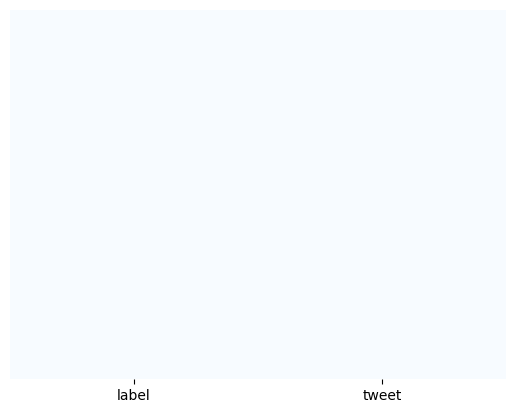

In [8]:
# Another way to check for any null values using seaborn
sns.heatmap(tweets_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

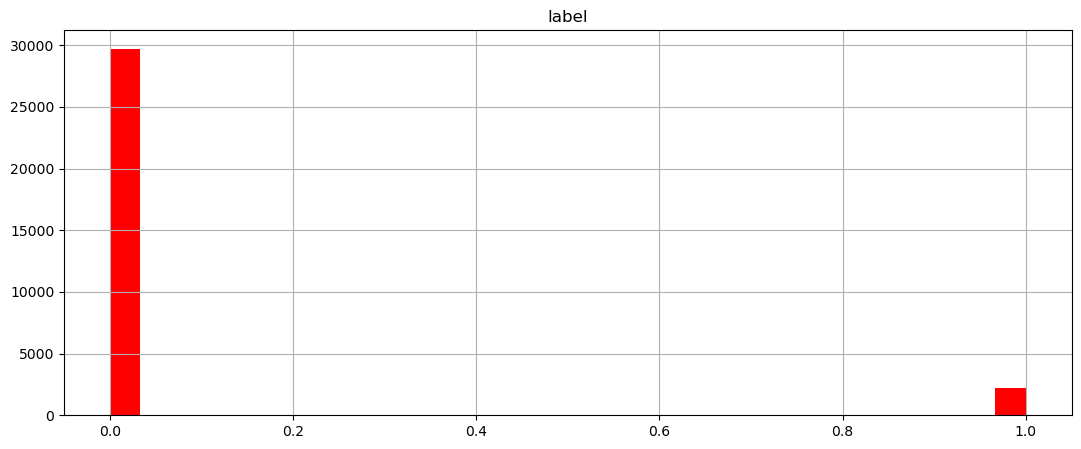

In [9]:
# Get a visual on the number of positive vs. negative tweets using Hist
tweets_df.hist(bins = 30, figsize = (13,5), color = 'r')

<AxesSubplot:xlabel='label', ylabel='count'>

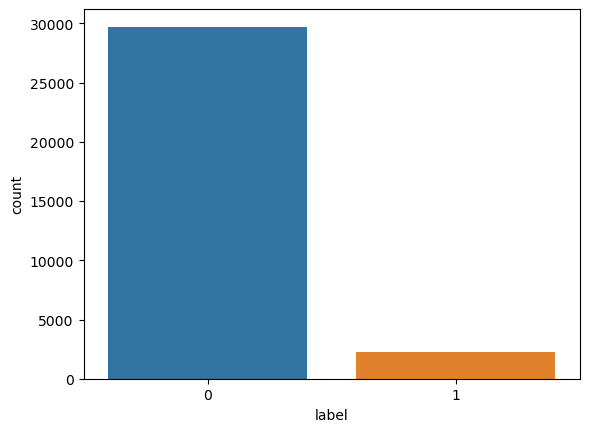

In [10]:
# Using seaborn to plot the same count as above
sns.countplot(data = tweets_df, x = 'label')

In [11]:
# More data exploration: We can check length of the messages
tweets_df['length'] = tweets_df['tweet'].apply(len)

In [12]:
tweets_df

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39
...,...,...,...
31957,0,ate @user isz that youuu?ðððððð...,68
31958,0,to see nina turner on the airwaves trying to...,131
31959,0,listening to sad songs on a monday morning otw...,63
31960,1,"@user #sikh #temple vandalised in in #calgary,...",67


In [13]:
tweets_df.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


<AxesSubplot:ylabel='Frequency'>

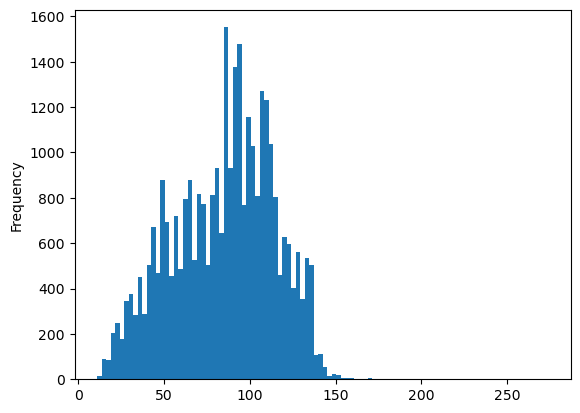

In [14]:
# Plot the histogram of the length column
tweets_df['length'].plot(bins=100, kind='hist') 

In [15]:
# Let's look at the positive tweets and draw a corresponding word cloud
# We cold also run the same code for the negative tweets where the label is 1
positive = tweets_df[tweets_df['label']==0]
positive

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39
...,...,...,...
31956,0,off fishing tomorrow @user carnt wait first ti...,61
31957,0,ate @user isz that youuu?ðððððð...,68
31958,0,to see nina turner on the airwaves trying to...,131
31959,0,listening to sad songs on a monday morning otw...,63


# Perform Data Clean Up <a class="anchor" id="data-cleanup"></a>

In [16]:
# Define a pipeline to clean up all the messages:
#     (1) Remove punctuation
#     (2) Remove stopwords
#     (3) Remove non-ascii chars

def message_cleaning(message):
    
    # Remove all punctuations
    clean_text = [char for char in message if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    
    # Remove all stopwords (e.g. was, were, the, and, ...) and any other extraneous words
    allstopwords = stopwords.words('english') + ['user', 'amp', 'got']
    clean_text = [word for word in re.split("\W+", clean_text) if word.lower() not in allstopwords]
    clean_text = ' '.join(clean_text)

    # Remove non-ascii characters (e.g. ^\x00-\x7f)
    clean_text = clean_text.encode('ascii', 'ignore').decode('ascii')
    
    return clean_text


In [17]:
# We run the pipeline for the our dataset's tweets column to clean up the data
tweets_df_clean = tweets_df['tweet'].apply(message_cleaning)

In [18]:
# Quick data check post cleaning
tweets_df_clean

0         father dysfunctional selfish drags kids dysfu...
1        thanks lyft credit cant use cause dont offer w...
2                                           bihday majesty
3                      model love u take u time ur        
4                            factsguide society motivation
                               ...                        
31957                             ate isz youuu           
31958     see nina turner airwaves trying wrap mantle g...
31959     listening sad songs monday morning otw work sad 
31960     sikh temple vandalised calgary wso condemns act 
31961                                        thank follow 
Name: tweet, Length: 31962, dtype: object

In [19]:
# Convert the column to a single string so we can feed it to the Wordcloud
all_tweets = " ".join(tweets_df_clean)

In [20]:
# Check the entire tweets data as one string -currently commented out due to text size
# all_tweets

# Plot the Wordcloud <a class="anchor" id="wordcloud"></a>

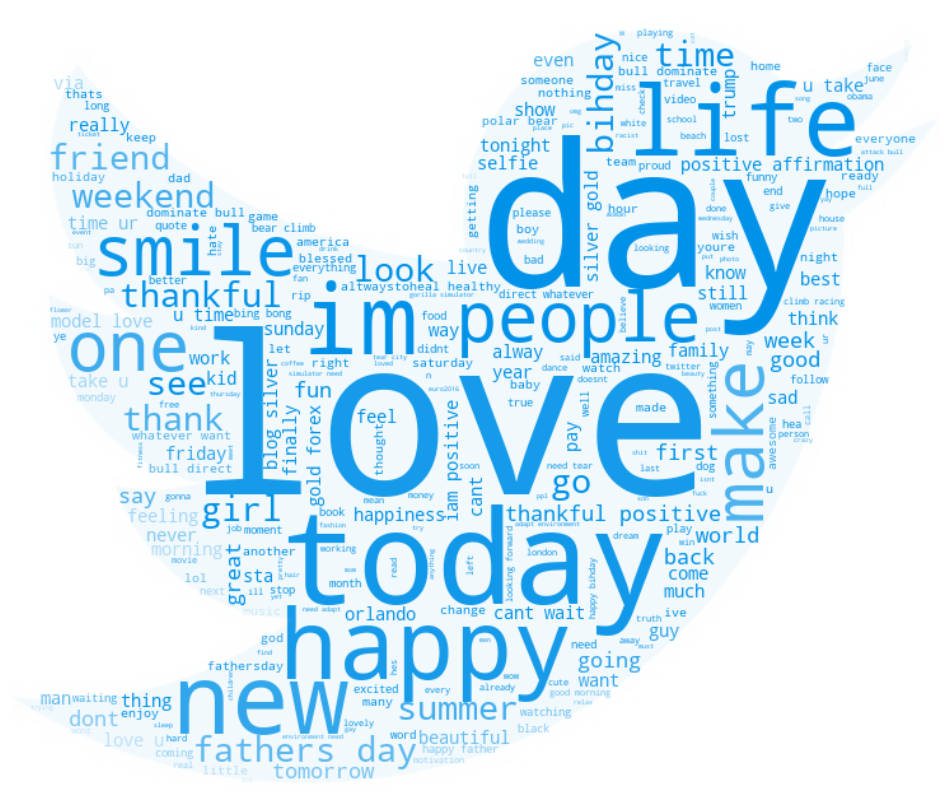

In [21]:
# We will be using the Twitter logo as a mask to display the wordcloud

bird_mask = np.array(Image.open("twitter_blue_on_white.png"))
image_colors = ImageColorGenerator(bird_mask)

wc = WordCloud(background_color="white", 
                        mode="RGBA", 
                        max_words=300, 
                        repeat=True,
                        mask=bird_mask)

# Redraw by using the main color of the image (blue) for the text
wc.generate(all_tweets)
wc.recolor(color_func = image_colors)

# Overlay the image with the text using a lighter color as the background
wc_img = Image.fromarray(wc.to_array())
bird_mask_img = Image.fromarray(bird_mask)
blended_img = Image.blend(wc_img, 
                      bird_mask_img, 
                      0.05)

# Display the overlayed image
plt.figure(figsize=(12,18), frameon = False)
plt.imshow(blended_img, interpolation = "bilinear")
plt.axis("off")
plt.show()


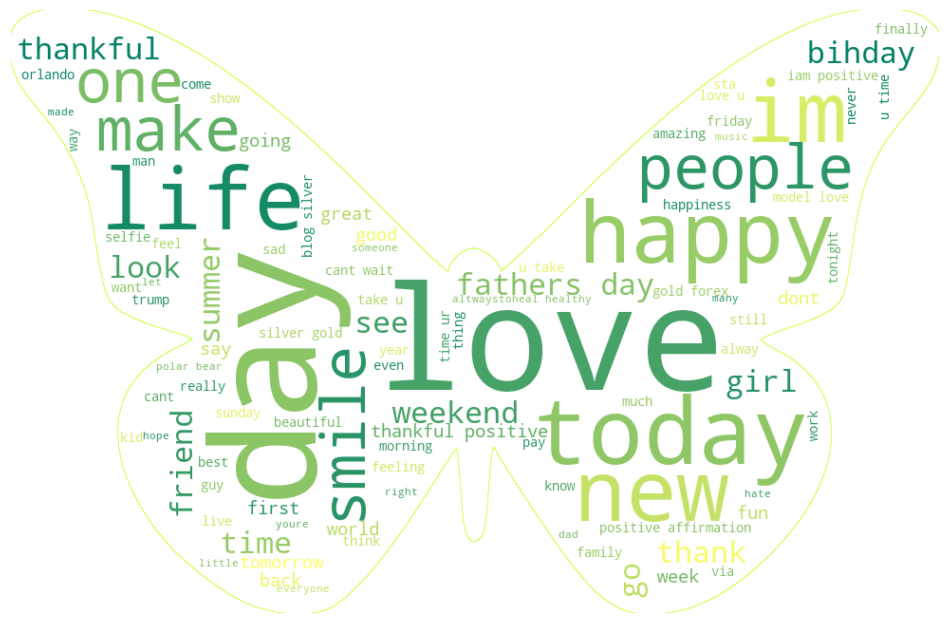

In [22]:
# Now we use a butterfly image as a mask to display the wordcloud
# Here, we use the wordcloud colormap 'summer' for the text color,
# other options: 'Wistia' and 'winter'

mask = np.array(Image.open('butterfly.png'))

wc = WordCloud(background_color = "white", 
               mask = mask,
               max_words = 100,
               contour_color = '#D7FF66',
               contour_width = 1,
               colormap = 'summer', 
               repeat = True
              )

plt.figure(figsize=(12,18),frameon = False)
plt.axis("off")
plt.imshow(wc.generate(all_tweets), interpolation="bilinear")